<a href="https://colab.research.google.com/github/DanielRasho/Paralela-proj3/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto 3 - Detección de líneas

- Daniel Rayo
- Nahomy Castro
- Xavier López
- Irving Acosta

### Instalación de CUDA

In [1]:
# Install CUDA C++ plugin for Colab:
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmph8uxr53g".


In [2]:
# Detect selected GPU and its NVIDA architecture:
import subprocess
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits")
if "not found" in gpu_info.lower(): raise RuntimeError("Error: No GPU found. Please select a GPU runtime environment.")
gpu_name, compute_cap = map(str.strip, gpu_info.split(','))
gpu_arch = f"sm_{compute_cap.replace('.', '')}"

print(f"{'GPU Name':<15}: {gpu_name}")
print(f"{'Architecture':<15}: {gpu_arch}")

GPU Name       : Tesla T4
Architecture   : sm_75


## Funcionamiento del algoritmo

## Generacion de PGM

Para probar el algoritmo con diferentes tipos de entradas, a continuación se muestra el script utilizado para poder transformar imagenes corrientes en su versión pgm.

In [2]:
# Dependencias
# !pip install opencv-python

In [8]:
# EXECUTE JUST ONCE!!!!
!rm -rf ./media
!git clone --depth 1 https://github.com/opencv/opencv.git
!mkdir -p ./media/
!mkdir -p ./media/raw
!cp -r opencv/samples/data/* ./media/raw
!rm -rf opencv
!rm -rf ./media/raw/aruco ./media/raw/dnn/

Cloning into 'opencv'...
remote: Enumerating objects: 9126, done.
remote: Counting objects: 100% (9126/9126), done.
remote: Compressing objects: 100% (7794/7794), done.
remote: Total 9126 (delta 1430), reused 4713 (delta 893), pack-reused 0 (from 0)
Receiving objects: 100% (9126/9126), 89.53 MiB | 16.58 MiB/s, done.
Resolving deltas: 100% (1430/1430), done.
Updating files: 100% (7664/7664), done.


In [10]:
import cv2
from pathlib import Path

input_dir = Path("./media/raw")
output_dir = Path("./media/pgm")
output_dir.mkdir(parents=True, exist_ok=True)

LOW_THRESH, HIGH_THRESH = 100, 200

# Gather only supported files
files = [f for f in input_dir.iterdir() if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]

for i, file in enumerate(sorted(files)):
    img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"⚠️ Could not read {file}, skipping.")
        continue

    blur = cv2.GaussianBlur(img, (3, 3), 0)
    edges = cv2.Canny(blur, LOW_THRESH, HIGH_THRESH)

    output_path = output_dir / f"{i}.pgm"
    cv2.imwrite(str(output_path), edges)

print("🎉 Finished processing all PNG/JPG images.")


🎉 Finished processing all PNG/JPG images.


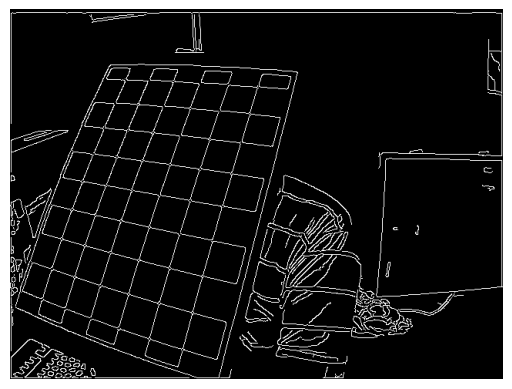

In [27]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("./media/pgm/76.pgm", cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

## Memoria Global

1.   List item
2.   List item



In [4]:
%%cuda -c "--gpu-architecture $gpu_arch"

#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include <string.h>
#include "common/pgm.h"

const int degreeInc = 2;
const int degreeBins = 180 / degreeInc;
const int rBins = 100;
const float radInc = degreeInc * M_PI / 180;
//*****************************************************************
// The CPU function returns a pointer to the accummulator
void CPU_HoughTran (unsigned char *pic, int w, int h, int **acc)
{
  float rMax = sqrt (1.0 * w * w + 1.0 * h * h) / 2;  //(w^2 + h^2)/2, radio max equivalente a centro -> esquina
  *acc = new int[rBins * degreeBins];            //el acumulador, conteo depixeles encontrados, 90*180/degInc = 9000
  memset (*acc, 0, sizeof (int) * rBins * degreeBins); //init en ceros
  int xCent = w / 2;
  int yCent = h / 2;
  float rScale = 2 * rMax / rBins;

  for (int i = 0; i < w; i++) //por cada pixel
    for (int j = 0; j < h; j++) //...
      {
        int idx = j * w + i;
        if (pic[idx] > 0) //si pasa thresh, entonces lo marca
          {
            int xCoord = i - xCent;
            int yCoord = yCent - j;  // y-coord has to be reversed
            float theta = 0;         // actual angle
            for (int tIdx = 0; tIdx < degreeBins; tIdx++) //add 1 to all lines in that pixel
              {
                float r = xCoord * cos (theta) + yCoord * sin (theta);
                int rIdx = (r + rMax) / rScale;
                (*acc)[rIdx * degreeBins + tIdx]++; //+1 para este radio r y este theta
                theta += radInc;
              }
          }
      }
}

//*****************************************************************
// TODO usar memoria constante para la tabla de senos y cosenos
// inicializarlo en main y pasarlo al device
//__constant__ float d_Cos[degreeBins];
//__constant__ float d_Sin[degreeBins];

//*****************************************************************
//TODO Kernel memoria compartida
// __global__ void GPU_HoughTranShared(...)
// {
//   //TODO
// }
//TODO Kernel memoria Constante
// __global__ void GPU_HoughTranConst(...)
// {
//   //TODO
// }

// GPU kernel. One thread per image pixel is spawned.
// The accummulator memory needs to be allocated by the host in global memory
__global__ void GPU_HoughTran (unsigned char *pic, int w, int h, int *acc, float rMax, float rScale, float *d_Cos, float *d_Sin)
{
  //TODO calcular: int gloID = ?
  int gloID = w * h + 1; //TODO
  if (gloID > w * h) return;      // in case of extra threads in block

  int xCent = w / 2;
  int yCent = h / 2;

  //TODO explicar bien bien esta parte. Dibujar un rectangulo a modo de imagen sirve para visualizarlo mejor
  int xCoord = gloID % w - xCent;
  int yCoord = yCent - gloID / w;

  //TODO eventualmente usar memoria compartida para el acumulador

  if (pic[gloID] > 0)
    {
      for (int tIdx = 0; tIdx < degreeBins; tIdx++)
        {
          //TODO utilizar memoria constante para senos y cosenos
          //float r = xCoord * cos(tIdx) + yCoord * sin(tIdx); //probar con esto para ver diferencia en tiempo
          float r = xCoord * d_Cos[tIdx] + yCoord * d_Sin[tIdx];
          int rIdx = (r + rMax) / rScale;
          //debemos usar atomic, pero que race condition hay si somos un thread por pixel? explique
          atomicAdd (acc + (rIdx * degreeBins + tIdx), 1);
        }
    }

  //TODO eventualmente cuando se tenga memoria compartida, copiar del local al global
  //utilizar operaciones atomicas para seguridad
  //faltara sincronizar los hilos del bloque en algunos lados

}

//*****************************************************************
int main (int argc, char **argv)
{
  int i;

  PGMImage inImg (argv[1]);

  int *cpuht;
  int w = inImg.x_dim;
  int h = inImg.y_dim;

  float* d_Cos;
  float* d_Sin;

  cudaMalloc ((void **) &d_Cos, sizeof (float) * degreeBins);
  cudaMalloc ((void **) &d_Sin, sizeof (float) * degreeBins);

  // CPU calculation
  CPU_HoughTran(inImg.pixels, w, h, &cpuht);

  // pre-compute values to be stored
  float *pcCos = (float *) malloc (sizeof (float) * degreeBins);
  float *pcSin = (float *) malloc (sizeof (float) * degreeBins);
  float rad = 0;
  for (i = 0; i < degreeBins; i++)
  {
    pcCos[i] = cos (rad);
    pcSin[i] = sin (rad);
    rad += radInc;
  }

  float rMax = sqrt (1.0 * w * w + 1.0 * h * h) / 2;
  float rScale = 2 * rMax / rBins;

  // TODO eventualmente volver memoria global
  cudaMemcpy(d_Cos, pcCos, sizeof (float) * degreeBins, cudaMemcpyHostToDevice);
  cudaMemcpy(d_Sin, pcSin, sizeof (float) * degreeBins, cudaMemcpyHostToDevice);

  // setup and copy data from host to device
  unsigned char *d_in, *h_in;
  int *d_hough, *h_hough;

  h_in = inImg.pixels; // h_in contiene los pixeles de la imagen

  h_hough = (int *) malloc (degreeBins * rBins * sizeof (int));

  cudaMalloc ((void **) &d_in, sizeof (unsigned char) * w * h);
  cudaMalloc ((void **) &d_hough, sizeof (int) * degreeBins * rBins);
  cudaMemcpy (d_in, h_in, sizeof (unsigned char) * w * h, cudaMemcpyHostToDevice);
  cudaMemset (d_hough, 0, sizeof (int) * degreeBins * rBins);

  // execution configuration uses a 1-D grid of 1-D blocks, each made of 256 threads
  //1 thread por pixel
  int blockNum = ceil (w * h / 256);
  GPU_HoughTran <<< blockNum, 256 >>> (d_in, w, h, d_hough, rMax, rScale, d_Cos, d_Sin);

  // get results from device
  cudaMemcpy (h_hough, d_hough, sizeof (int) * degreeBins * rBins, cudaMemcpyDeviceToHost);

  // compare CPU and GPU results
  for (i = 0; i < degreeBins * rBins; i++)
  {
    if (cpuht[i] != h_hough[i])
      printf ("Calculation mismatch at : %i %i %i\n", i, cpuht[i], h_hough[i]);
  }
  printf("Done!\n");

  // TODO clean-up

  return 0;
}

/tmp/tmph8uxr53g/fb71058d-442e-4483-a143-5c90e8462f82/single_file.cu:7:10: fatal error: common/pgm.h: No such file or directory
    7 | #include "common/pgm.h"
      |          ^~~~~~~~~~~~~~
compilation terminated.

